In [1]:
import pandas as pd
import numpy as np 
df = pd.read_excel('/Users/chase/Downloads/bpdata.xlsx')

In [2]:
df.head()

,date,y,t,g,trend,trend2,dum75q2,rrtaxu
0,1950-01-01,-428.265747,-1081.332153,-1117.348755,1,1,0,0.0
1,1950-04-01,-425.807556,-1072.665527,-1116.824219,2,4,0,0.0
2,1950-07-01,-422.493561,-1062.218994,-1121.543823,3,9,0,0.0
3,1950-10-01,-421.014496,-1055.743774,-1112.510742,4,16,0,0.0
4,1951-01-01,-420.063110,-1046.365845,-1094.527344,5,25,0,0.0


In [3]:
df.index = df.date
df.index = pd.to_datetime(df.index)

In [4]:
def gen_lags(df, variable, number_of_lags):
    lag = 1
    while lag < number_of_lags + 1:
        df[str(variable) + '-' +str(lag)] = df[str(variable)].shift(lag)
        lag +=1
    return df
        



In [5]:
variables = ['y', 't', 'g']

for variable in variables:
    gen_lags(df, variable, 4)

In [6]:
df.head()

,date,y,t,g,trend,trend2,dum75q2,rrtaxu,y-1,y-2,y-3,y-4,t-1,t-2,t-3,t-4,g-1,g-2,g-3,g-4
date,,,,,,,,,,,,,,,,,,,,
1950-01-01,1950-01-01,-428.265747,-1081.332153,-1117.348755,1,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-04-01,1950-04-01,-425.807556,-1072.665527,-1116.824219,2,4,0,0.0,-428.265747,NaN,NaN,NaN,-1081.332153,NaN,NaN,NaN,-1117.348755,NaN,NaN,NaN
1950-07-01,1950-07-01,-422.493561,-1062.218994,-1121.543823,3,9,0,0.0,-425.807556,-428.265747,NaN,NaN,-1072.665527,-1081.332153,NaN,NaN,-1116.824219,-1117.348755,NaN,NaN
1950-10-01,1950-10-01,-421.014496,-1055.743774,-1112.510742,4,16,0,0.0,-422.493561,-425.807556,-428.265747,NaN,-1062.218994,-1072.665527,-1081.332153,NaN,-1121.543823,-1116.824219,-1117.348755,NaN
1951-01-01,1951-01-01,-420.063110,-1046.365845,-1094.527344,5,25,0,0.0,-421.014496,-422.493561,-425.807556,-428.265747,-1055.743774,-1062.218994,-1072.665527,-1081.332153,-1112.510742,-1121.543823,-1116.824219,-1117.348755


In [7]:
df = df.dropna(axis = 0)

In [8]:
import statsmodels.api as sm # for OLS

X = df[['y-1', 'y-2', 'y-3','y-4', 'g-1', 'g-2', 'g-3','g-4','t-1', 't-2', 't-3','t-4']]
X = sm.add_constant(X)
estimates = {}
for variable in variables:
    estimates[str(variable)] = sm.OLS(df[str(variable)],X).fit()
    df['e_' + str(variable)] =  estimates[str(variable)].resid

Here I construct the residuals from the timing assumption of the VAR 

In [9]:
df['res'] = df['e_t'] - 2.08* df['e_g']
X = df[['e_g', 'e_t']]
X = sm.add_constant(X)
reg1 = sm.OLS(df['e_y'] ,X).fit()
reg1predict = reg1.fittedvalues
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    e_y   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     35.58
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           3.76e-14
Time:                        12:41:54   Log-Likelihood:                -247.21
No. Observations:                 228   AIC:                             500.4
Df Residuals:                     225   BIC:                             510.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.911e-12      0.048  -1.03e-10      1.000      -0.094       0.094
e_g            0.0653      0.023      2.853      0.005       0.020       0.110
e_t            0.1387      0.018      7.699      0.000       0.103       0.174
==============================================================================
Omnibus:                       10.188   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               21.296
Skew:                           0.057   Prob(JB):                     2.38e-05
Kurtosis:                       4.493   Cond. No.                         2.67
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
df['res'] = df['e_t'] - 2.08* df['e_y']
X = df[['e_g', 'res']]
X = sm.add_constant(X)
firststage1 = sm.OLS(df['e_t'] ,X).fit()
df['fs1'] = firststage1.fittedvalues
firststage1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    e_t   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     182.1
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           9.29e-48
Time:                        12:41:54   Log-Likelihood:                -436.52
No. Observations:                 228   AIC:                             879.0
Df Residuals:                     225   BIC:                             889.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.319e-12      0.109  -3.03e-11      1.000      -0.216       0.216
e_g            0.1545      0.052      2.947      0.004       0.051       0.258
res            0.8655      0.046     18.994      0.000       0.776       0.955
==============================================================================
Omnibus:                       13.319   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.205
Skew:                          -0.154   Prob(JB):                     1.67e-07
Kurtosis:                       4.786   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
## looks like by the f-stat it is a strong instrument

X = df[['fs1','e_g']]
X = sm.add_constant(X)
secondstage1 = sm.OLS(df['e_y'] ,X).fit()
secondstage1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    e_y   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     9.235
Date:                Tue, 03 Mar 2020   Prob (F-statistic):           0.000140
Time:                        12:41:54   Log-Likelihood:                -269.54
No. Observations:                 228   AIC:                             545.1
Df Residuals:                     225   BIC:                             555.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.844e-12      0.053   -3.5e-11      1.000      -0.104       0.104
fs1           -0.0747      0.025     -2.951      0.004      -0.125      -0.025
e_g            0.0858      0.025      3.395      0.001       0.036       0.136
==============================================================================
Omnibus:                       13.319   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.205
Skew:                          -0.154   Prob(JB):                     1.67e-07
Kurtosis:                       4.786   Cond. No.                         2.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:

X = df[['g','t','y-1', 'y-2', 'y-3','y-4', 'g-1', 'g-2', 'g-3','g-4','t-1', 't-2', 't-3','t-4']]
X = sm.add_constant(X)
reg2 = sm.OLS(df['y'],X).fit()
reg2.summary()
## Note how this is the same as the residual regression for the point estimates on t and g. 


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.851e+04
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:41:54   Log-Likelihood:                -247.21
No. Observations:                 228   AIC:                             524.4
Df Residuals:                     213   BIC:                             575.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.6188     11.204     -0.323      0.747     -25.704      18.466
g              0.0653      0.024      2.776      0.006       0.019       0.112
t              0.1387      0.019      7.491      0.000       0.102       0.175
y-1            1.1515      0.070     16.487      0.000       1.014       1.289
y-2           -0.1397      0.103     -1.352      0.178      -0.343       0.064
y-3           -0.0101      0.102     -0.099      0.921      -0.211       0.191
y-4            0.0067      0.069      0.096      0.923      -0.130       0.143
g-1           -0.0949      0.037     -2.593      0.010      -0.167      -0.023
g-2            0.0779      0.036      2.180      0.030       0.007       0.148
g-3           -0.0892      0.035     -2.538      0.012      -0.159      -0.020
g-4            0.0430      0.022      1.978      0.049       0.000       0.086
t-1           -0.1034      0.024     -4.249      0.000      -0.151      -0.055
t-2           -0.0444      0.025     -1.764      0.079      -0.094       0.005
t-3           -0.0381      0.025     -1.522      0.130      -0.087       0.011
t-4            0.0380      0.020      1.867      0.063      -0.002       0.078
==============================================================================
Omnibus:                       10.188   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               21.296
Skew:                           0.057   Prob(JB):                     2.38e-05
Kurtosis:                       4.493   Cond. No.                     7.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
X = df[['g','res','y-1', 'y-2', 'y-3','y-4', 'g-1', 'g-2', 'g-3','g-4','t-1', 't-2', 't-3','t-4']]
X = sm.add_constant(X)
firststage2 = sm.OLS(df['t'] ,X).fit()
df['fs2'] = firststage2.fittedvalues
firststage2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      t   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     8184.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):          3.01e-282
Time:                        12:41:54   Log-Likelihood:                -436.52
No. Observations:                 228   AIC:                             903.0
Df Residuals:                     213   BIC:                             954.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -141.7378     24.905     -5.691      0.000    -190.829     -92.646
g              0.1545      0.054      2.868      0.005       0.048       0.261
res            0.8655      0.047     18.481      0.000       0.773       0.958
y-1            1.1065      0.153      7.216      0.000       0.804       1.409
y-2           -0.7281      0.235     -3.097      0.002      -1.192      -0.265
y-3           -0.0781      0.234     -0.334      0.739      -0.540       0.383
y-4           -0.0990      0.159     -0.625      0.533      -0.412       0.214
g-1           -0.3127      0.083     -3.748      0.000      -0.477      -0.148
g-2            0.0123      0.082      0.149      0.881      -0.149       0.174
g-3            0.2441      0.080      3.053      0.003       0.086       0.402
g-4           -0.1277      0.050     -2.576      0.011      -0.225      -0.030
t-1            0.7024      0.047     14.926      0.000       0.610       0.795
t-2            0.2018      0.057      3.533      0.001       0.089       0.314
t-3           -0.1044      0.057     -1.823      0.070      -0.217       0.009
t-4            0.0166      0.047      0.354      0.724      -0.076       0.109
==============================================================================
Omnibus:                       13.319   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.205
Skew:                          -0.154   Prob(JB):                     1.67e-07
Kurtosis:                       4.786   Cond. No.                     7.00e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  7e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
X = df[['fs2','g','y-1', 'y-2', 'y-3','y-4', 'g-1', 'g-2', 'g-3','g-4','t-1', 't-2', 't-3','t-4']]
X = sm.add_constant(X)
secondstage2 = sm.OLS(df['y'],X).fit()
secondstage2.summary()

## Note they both match

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.166e+04
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:41:58   Log-Likelihood:                -269.54
No. Observations:                 228   AIC:                             569.1
Df Residuals:                     213   BIC:                             620.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.6235     12.592     -2.829      0.005     -60.443     -10.803
fs2           -0.0747      0.026     -2.871      0.005      -0.126      -0.023
g              0.0858      0.026      3.303      0.001       0.035       0.137
y-1            1.3851      0.079     17.526      0.000       1.229       1.541
y-2           -0.2926      0.115     -2.554      0.011      -0.518      -0.067
y-3           -0.0286      0.113     -0.254      0.799      -0.251       0.193
y-4           -0.0111      0.076     -0.146      0.884      -0.161       0.139
g-1           -0.1468      0.041     -3.618      0.000      -0.227      -0.067
g-2            0.0787      0.039      1.995      0.047       0.001       0.156
g-3           -0.0366      0.039     -0.940      0.348      -0.113       0.040
g-4            0.0135      0.024      0.561      0.575      -0.034       0.061
t-1            0.0476      0.029      1.631      0.104      -0.010       0.105
t-2           -0.0016      0.028     -0.059      0.953      -0.057       0.053
t-3           -0.0608      0.028     -2.196      0.029      -0.115      -0.006
t-4            0.0401      0.022      1.784      0.076      -0.004       0.084
==============================================================================
Omnibus:                       13.319   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.205
Skew:                          -0.154   Prob(JB):                     1.67e-07
Kurtosis:                       4.786   Cond. No.                     7.72e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
## Now I will my results match statsmodel VAR estimation to see if they are similar
import statsmodels.tsa.api as ts
Y = df[['y','g','t']]
Y.index = df.index
model = ts.VAR(Y)

/Users/chase/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


In [43]:
results = model.fit(4)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Mar, 2020
Time:                     12:58:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.35228
Nobs:                     224.000    HQIC:                   2.99805
Log likelihood:          -1223.45    FPE:                    15.7790
AIC:                      2.75829    Det(Omega_mle):         13.3223
--------------------------------------------------------------------
Results for equation y
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -31.832350        12.418381           -2.563           0.010
L1.y          1.296238         0.078506           16.511           0.000
L1.g         -0.054748         0.030319           -1.806           0.071
L1.t         -0.000614 

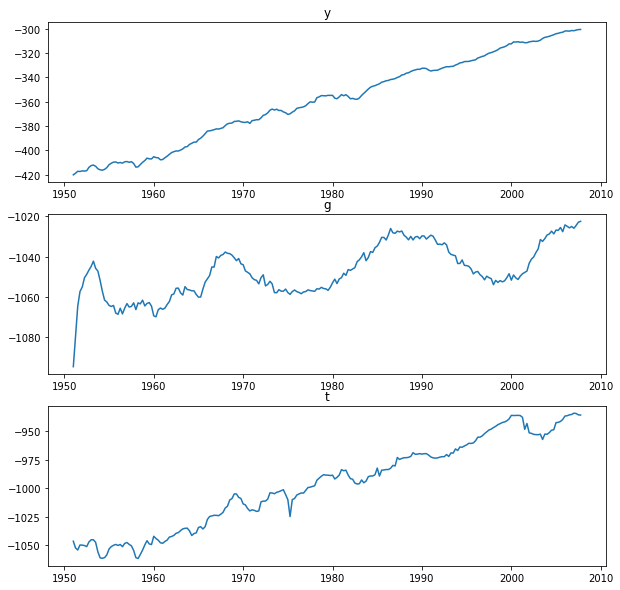

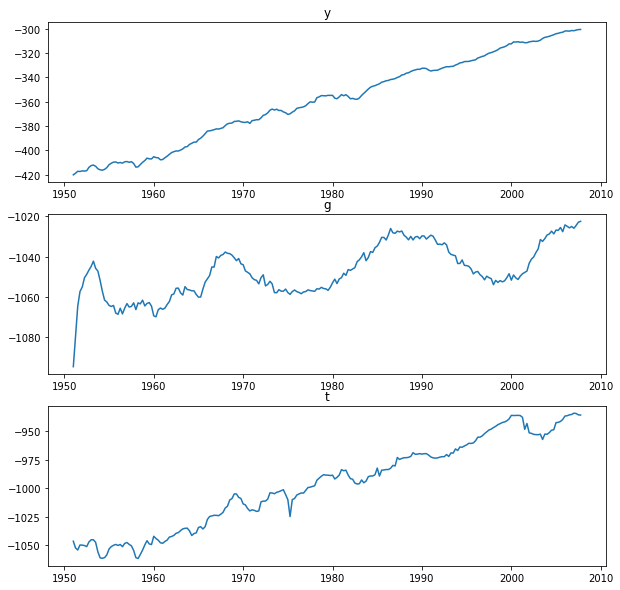

In [44]:
results.plot()

In [45]:
estimates['y'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.445e+04
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        12:58:42   Log-Likelihood:                -278.54
No. Observations:                 228   AIC:                             583.1
Df Residuals:                     215   BIC:                             627.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -35.6025     11.796     -3.018      0.003     -58.853     -12.352
y-1            1.2871      0.076     16.907      0.000       1.137       1.437
y-2           -0.2238      0.117     -1.914      0.057      -0.454       0.007
y-3           -0.0339      0.116     -0.291      0.771      -0.263       0.196
y-4            0.0162      0.079      0.206      0.837      -0.139       0.171
g-1           -0.0345      0.026     -1.310      0.191      -0.086       0.017
g-2            0.0666      0.041      1.639      0.103      -0.013       0.147
g-3           -0.0518      0.040     -1.303      0.194      -0.130       0.027
g-4            0.0096      0.024      0.396      0.693      -0.038       0.057
t-1            0.0019      0.023      0.084      0.933      -0.044       0.048
t-2           -0.0184      0.028     -0.648      0.518      -0.074       0.038
t-3           -0.0554      0.029     -1.943      0.053      -0.112       0.001
t-4            0.0300      0.023      1.302      0.194      -0.015       0.075
==============================================================================
Omnibus:                       14.457   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               32.472
Skew:                          -0.227   Prob(JB):                     8.89e-08
Kurtosis:                       4.792   Cond. No.                     6.29e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

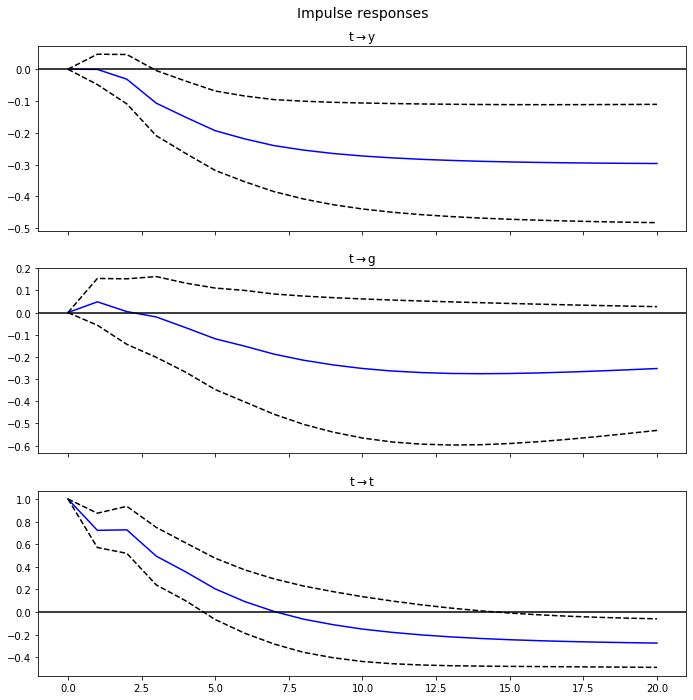

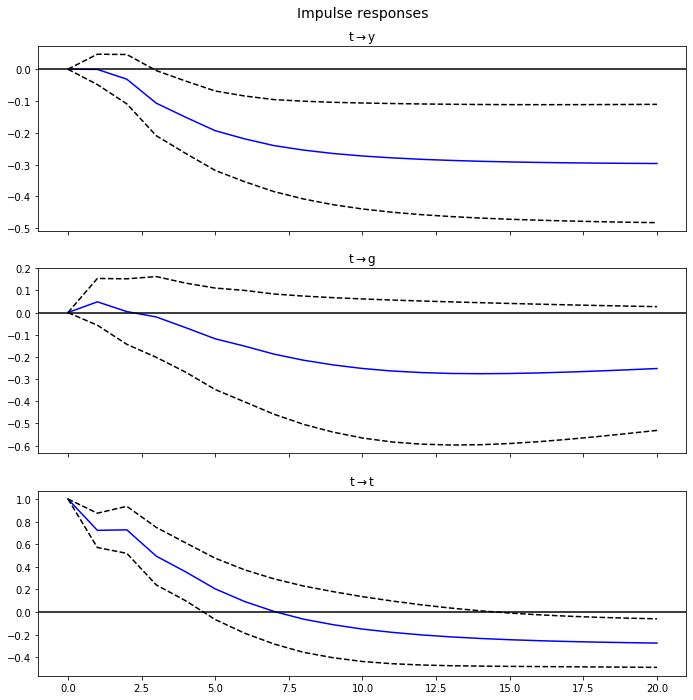

In [46]:
irf = results.irf(20)
irf.plot(impulse = 't')